# **Linear Regression III**

---

### **Introduction**
This notebook goes over the basics of linear regression.

---

### **Author**
**Junichi Koganemaru**  

---

### **References**
1. Elements of Statistical Learning by Trevor Hastie, Robert Tibshirani, and Jerome Friedman.
2. Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani.
3. All of Statistics: A Concise Course in Statistical Inference by Larry Wasserman.

---

### **Recommended Reading and Resources**

1. [Power transform](https://en.wikipedia.org/wiki/Power_transform)
2. [Polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression)
3. [Generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model)

---

### **Last Updated**
**February 3, 2025**

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from scipy.stats import chi2
from scipy.stats import boxcox
from scipy.stats import probplot
from scipy.stats import yeojohnson
from scipy.stats import laplace
import warnings

In [13]:
warnings.filterwarnings('ignore')

## Discrete variables 

In the previous notebooks on linear regression, we treated all the features as continuous variables. However, in practice one can also encounter features that are discrete. An example of this are *count variables*, which are used to count the number of times an event occurs. For example, the number of times a user logs into a website, the number of times a user clicks on an ad, etc. 

Sometimes discrete variables can be treated as continuous variables, but this is not always the case. This is especially true for *categorical variables*, which are numbers that are merely *labels* for different categories. For example, one can use the numbers 1, 2, and 3 to represent the categories "red", "green", and "blue". The number of labels are usually referred to as *levels*.

To incorporate categorical variables into a regression model, one often introduces an *indicator variable* for each level of the categorical variable. For example, suppose we have a dataset on cars where the target variable is the price of the car, and there are two features. One of them is a continuous variable $X_1$, the number of miles the car has been driven, and the other is a categorical variable that represents the color of the car. If the color of the car can be "red" or "blue", then we can introduce an indicator variable $X_2$ that is 1 if the car is red and 0 if the car is blue. The linear regression model would then look like:

$$
y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \epsilon_i = \begin{cases}
\beta_0 + \beta_1 X_{1i} + \epsilon_i & \text{if car is red} \\
\beta_0 + \beta_1 X_{1i} + \beta_2 + \epsilon_i & \text{if car is blue},
\end{cases} \; 1 \le i \le n.
$$

Here we are treating the category "red" as a *baseline category*, and the coefficient $\beta_2$ represents the difference in price between a red car and a blue car. We note that another way to write the model is 
$$
y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 \boldsymbol{1}_{\{\text{color = blue}\}} + \epsilon_i, \; 1 \le i \le n.
$$

If there are more than two levels, one would need to introduce more indicator variables. For example, suppose instead of two colors there are three, say "red", "blue" and "green". We would introduce two indicator variables $X_2$ and $X_3$ such that $X_2 = 1$ if the car is blue and $X_3 = 1$ if the car is green. The linear regression model would then look like

$$
y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \beta_3 X_{3i} + \epsilon_i = \begin{cases}
\beta_0 + \beta_1 X_{1i} + \epsilon_i & \text{if car is red} \\
\beta_0 + \beta_1 X_{1i} + \beta_2 + \epsilon_i & \text{if car is blue} \\
\beta_0 + \beta_1 X_{1i} + \beta_3 + \epsilon_i & \text{if car is green},
\end{cases} \; 1 \le i \le n.
$$

Alternatively, we can write the model as
$$
y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 \boldsymbol{1}_{\{\text{color = blue}\}} + \beta_3 \boldsymbol{1}_{\{\text{color = green}\}} + \epsilon_i, \; 1 \le i \le n.
$$

In general, a categorical variable with $k$ levels introduces $k-1$ parameters in the model. 

### Design matrix with categorical variables

When we introduce indicator variables for categorical variables, we need to modify the design matrix. Since a categorical variable with $k$ levels introduces $k-1$ parameters, $k-1$ columns must be added to the design matrix $X$. To create the shift effect, these columns are filled with 0's and 1's. 

In [49]:
miles = np.round(np.random.uniform(1000, 100000, size=10), 1)
colors = np.random.choice(['red', 'blue', 'green'], size=10)

df = pd.DataFrame({'Miles': miles, 'Car color': colors})
df

,Miles,Car color
0,77260.0,red
1,98509.9,blue
2,70776.2,green
3,24249.9,red
4,84214.4,red
5,66770.7,red
6,31124.5,blue
7,77295.2,red
8,5627.9,blue
9,86443.2,green


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Miles      10 non-null     float64
 1   Car color  10 non-null     object 
dtypes: float64(1), object(1)
memory usage: 292.0+ bytes


In [51]:
color_dummies = pd.get_dummies(df['Car color'], drop_first=True).astype(int)
intercept = np.ones(len(df), dtype=int)

X_design = pd.concat([pd.Series(intercept, name='intercept column'), df['Miles'], color_dummies], axis=1)
X_design

,intercept column,Miles,green,red
0,1,77260.0,0,1
1,1,98509.9,0,0
2,1,70776.2,1,0
3,1,24249.9,0,1
4,1,84214.4,0,1
5,1,66770.7,0,1
6,1,31124.5,0,0
7,1,77295.2,0,1
8,1,5627.9,0,0
9,1,86443.2,1,0


In the sample code above, the ``get_dummies()`` function from ``pandas`` converts any variable labelled as a category variable into appropriate indicator variables using *one-hot encoding*. 

The drop_first argument is set to True to set one of the categories as a reference category. In this case, "blue" is set as a reference category as ["red", "blue", "green"] sorted alphabetically is ["blue", "green", "red"].

In general, if a model has $p$ categorical variables, each with $k_1, k_2, \ldots, k_p$ levels, then the total number of parameters introduced by the categorical variables is $k_1 + k_2 + \ldots + k_p - p$.

## Interaction terms

Interaction terms can be added to a linear regression model to capture the effect of the interaction between two features. For example, if a model has two features $X_1$ and $X_2$, an interaction term $X_1 \times X_2$ can be added to the model. The linear regression model would then look like
$$
y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \beta_3 X_{1i} X_{2i} + \epsilon_i, \; 1 \le i \le n.
$$

We note that this case the model is still linear *with respect to the parameters*. In matrix form, the model is still 
$$
\mathbf{y} = X\boldsymbol{\beta} + \boldsymbol{\epsilon},
$$
the only difference is that now the design matrix $X$ has an additional column that is the product of the columns corresponding to $X_1$ and $X_2$.

## Polynomial regression

An extension of linear regression is polynomial regression, where the features are raised to a power. For example, if a model has one feature $X$, then a polynomial regression model of degree $d$ would look like
$$
y_i = \beta_0 + \beta_1 X_{i} + \beta_2 X_{i}^2 + \cdots + \beta_d X_{i}^d + \epsilon_i, \; 1 \le i \le n.
$$

We note that this is *still* a linear model with respect to the parameters. In matrix form, the model is 
$$
\mathbf{y} = X\boldsymbol{\beta} + \boldsymbol{\epsilon},
$$
where the design matrix $X$ is of the form
$$
X = \begin{pmatrix}
1 & X_1 & X_1^2 & \cdots & X_1^d \\
1 & X_2 & X_2^2 & \cdots & X_2^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & X_n & X_n^2 & \cdots & X_n^d
\end{pmatrix}.
$$

This idea can also be extended to models with multiple features. For example, if a model has two features $X_1$ and $X_2$, then a polynomial regression model of degree $3$ would look like
$$
y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \beta_3 X_{1i}^2 + \beta_4 X_{2i}^2 + \beta_5 X_{1i} X_{2i} + \beta_6 X_{1i}^3 + \beta_7 X_{2i}^3 + \epsilon_i, \; 1 \le i \le n.
$$
The design matrix $X$ would then be of the form
$$
X = \begin{pmatrix}
1 & X_{11} & X_{21} & X_{11}^2 & X_{21}^2 & X_{11}X_{21} & X_{11}^3 & X_{21}^3 \\
1 & X_{12} & X_{22} & X_{12}^2 & X_{22}^2 & X_{12}X_{22} & X_{12}^3 & X_{22}^3 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & X_{1n} & X_{2n} & X_{1n}^2 & X_{2n}^2 & X_{1n}X_{2n} & X_{1n}^3 & X_{2n}^3
\end{pmatrix}.
$$

Polynomial regression, while useful, can present some challenges. For example, the number of parameters increase rapidly with the degree of the polynomial, which can lead to overfitting. In addition, the model can become more difficult to interpret as the degree of the polynomial increases.

In scitkit-learn, polynomial regression can be implemented using the ``PolynomialFeatures`` class from the ``preprocessing`` module. This class can be used on the feature data to automatically generate the design matrix with polynomial features.

### Basis function approach

Polynomial regression can be thought of as a special case of a more general approach The idea is that given a family of functions $\{f_1, f_2, \ldots, f_k\}$ where $f_k : \mathbb{R} \to \mathbb{R}^{n_k}$, one can create a model of the form
$$
y_i = \beta_0 +  f_1(X_i) \boldsymbol{\beta}_1 + f_2(X_i) \boldsymbol{\beta}_2 + \cdots +  f_k(X_i) \boldsymbol{\beta}_i + \epsilon_i, \; 1 \le i \le n, \boldsymbol{\beta}_k \in \mathbb{R}^{n_k}.
$$

The theoretical reason for using polynomial functions is partially due to the Stone-Weierstrass theorem, which states that any continuous function on a compact interval can be uniformly approximated by a polynomial function. In this sense, one can think of the polynomial functions as forming a basis (in the linear algebraic sense) for approximating continuous functions. In practice, other basis functions can be used, such as piecewise constant functions, the Fourier basis functions, the wavelet basis functions, etc.

### Splines 
A special case of this approach is the use of *splines*. A spline is a piecewise polynomial function that is continuous at the *knots*, which are the points where the polynomial pieces are joined.

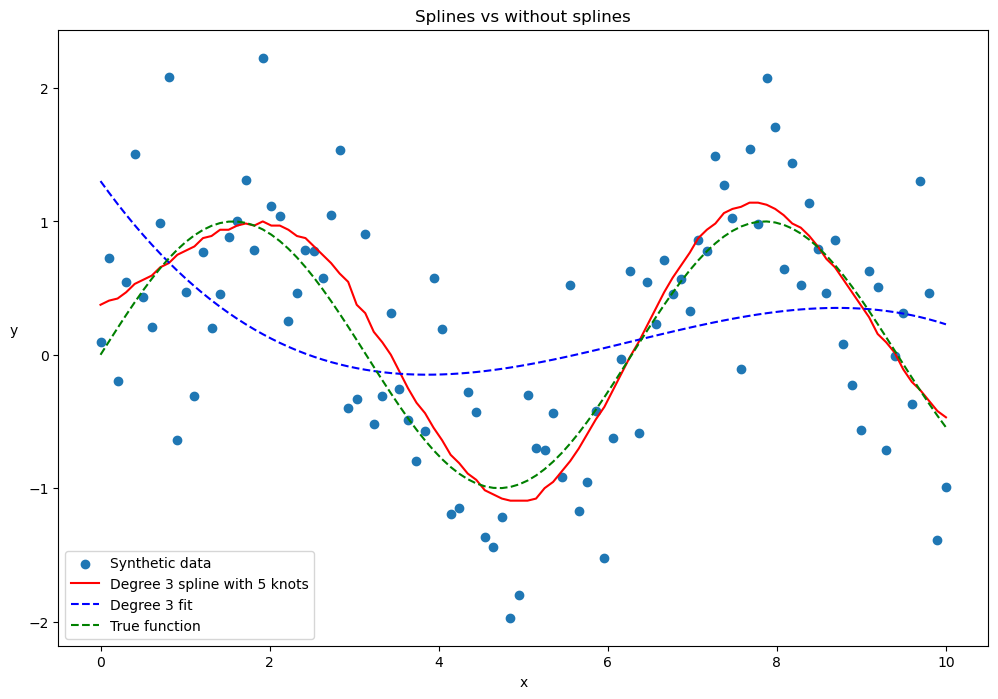

In [3]:
x = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)

SPLINE_DEGREE = 3
NUM_KNOTS = 5 

spline_transformer = SplineTransformer(degree=SPLINE_DEGREE, n_knots=NUM_KNOTS, include_bias=True)
X_spline = spline_transformer.fit_transform(x)

model_spline = LinearRegression()
model_spline.fit(X_spline, y)
y_spline_pred = model_spline.predict(X_spline)

DEGREE_WITHOUT_SPLINE = 3
X_quad = np.hstack([x**i for i in range(DEGREE_WITHOUT_SPLINE + 1)])

model_quad = LinearRegression()
model_quad.fit(X_quad, y)
y_quad_pred = model_quad.predict(X_quad)

plt.figure(figsize=(12, 8)) 
plt.scatter(x, y, label='Synthetic data')
plt.plot(x, y_spline_pred, color='red', label=f'Degree {SPLINE_DEGREE} spline with {NUM_KNOTS} knots')
plt.plot(x, y_quad_pred, color='blue', linestyle='--', label=f'Degree {DEGREE_WITHOUT_SPLINE} fit')
plt.plot(x, np.sin(x), color='green', linestyle='--', label='True function')
plt.xlabel('x')
plt.ylabel('y', rotation=0, labelpad=10)
plt.legend()
plt.title('Splines vs without splines')
plt.show()


## Power transformations

Next we briefly discuss power transformations. There are families of transformations that can be applied to a sample, with the explicit goal of maximizing the quality of the fit of a normal distribution to that sample.

In terms of linear regression, one can transform the response of a regression model with the goal of making the *residuals* more normally distributed. This is typically applied when the target is skewed and when the residuals exhibit heteroscedasticity.

### Box-Cox transformation
When the target variable is strictly positive, the *Box-Cox transformation* can be applied. The Box-Cox transformation is defined as
$$
y^{(\lambda)} = \begin{cases}
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\
\log(y) & \text{if } \lambda = 0.
\end{cases}
$$
This defines a wide range of possible transformations: including $\sqrt{y}, y^2, \log(y)$ etc. with shifts and scaling. We note that this family of transformations is continuous in $\lambda$. 

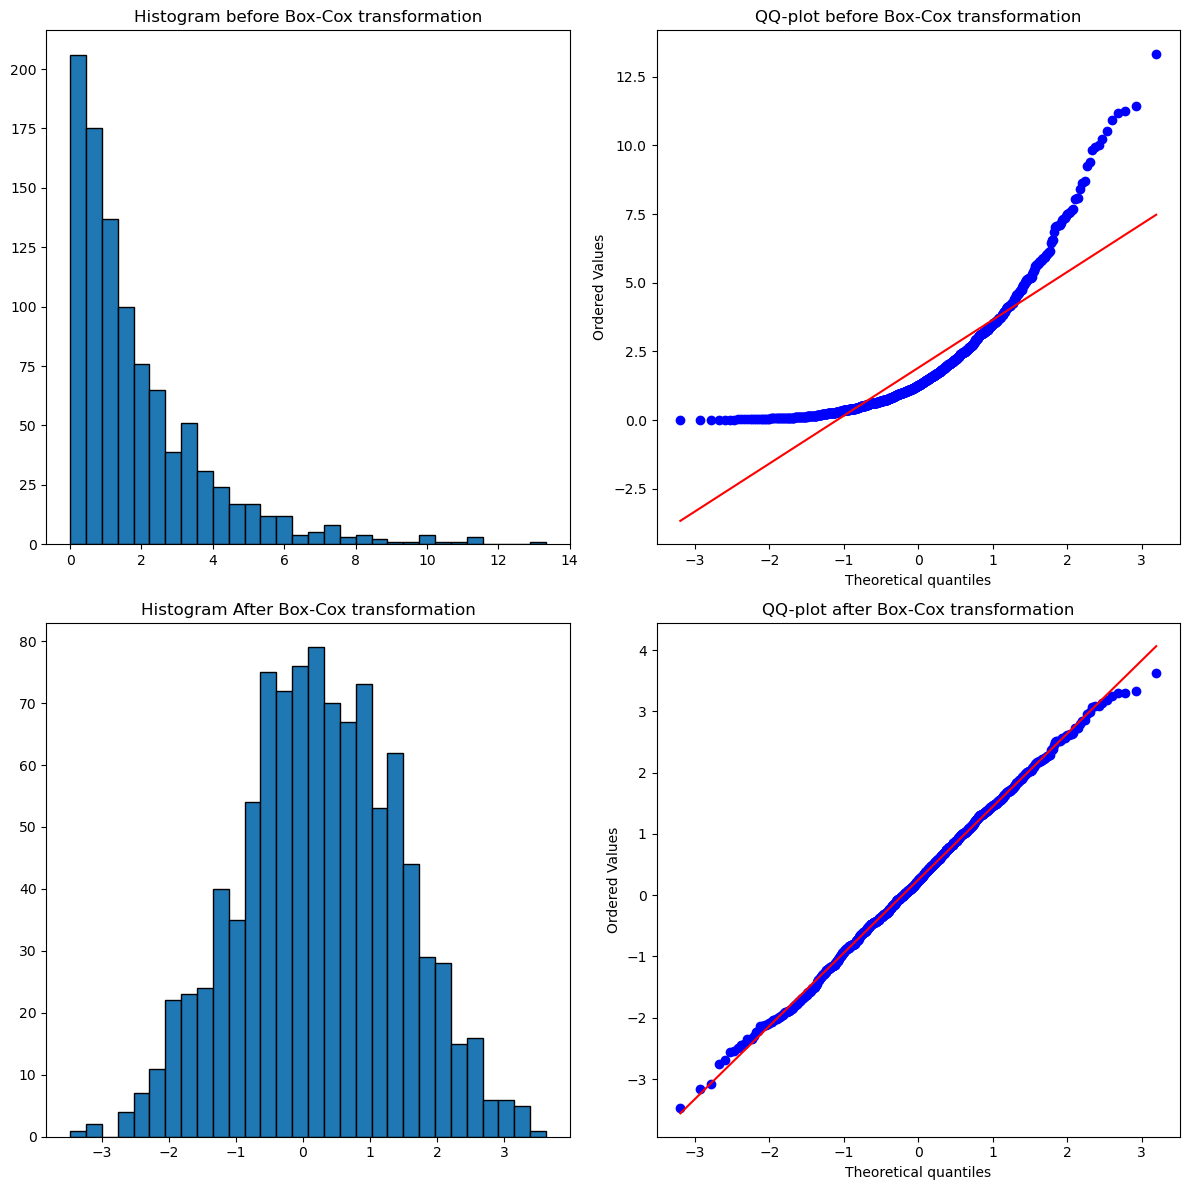

Optimal lambda = 0.24558573077375118
95% Confidence interval for lambda = (0.20346431242874355, 0.28877890440184095)


In [104]:
data = chi2.rvs(df=2, size=1000)

# The optimal lambda is the found via a maximum likelihood procedure
data_boxcox, lmbda, CI = boxcox(data, alpha=0.05)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].hist(data, bins=30, edgecolor='k')
axes[0, 0].set_title('Histogram before Box-Cox transformation')

probplot(data, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('QQ-plot before Box-Cox transformation')

axes[1, 0].hist(data_boxcox, bins=30, edgecolor='k')
axes[1, 0].set_title('Histogram After Box-Cox transformation')

probplot(data_boxcox, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('QQ-plot after Box-Cox transformation')

plt.tight_layout()
plt.show()
print(f'Optimal lambda = {lmbda}')
print(f'95% Confidence interval for lambda = {CI}')

One typically choose a "nice" value of $\lambda$ in the confidence interval for the sake of interpretability. For example, in this case we can choose $\lambda = 0.25$. 

The Box-Cox transformation has several disadvantages. 

1. It can only be applied to strictly positive target variables.
2. It cannot fundamentally correct a poor fitting model.
3. It can be hard to interpret the results of the model after the transformation, since inverting the Box-Cox transformation is possible but messy.

### Yeo-Johnson transformation

A generalization of the Box-Cox transformation is the *Yeo-Johnson transformation*, which can be applied to variables that take on non-positive values. The Yeo-Johnson transformation is defined as
$$
y^{(\lambda)} = \begin{cases}
\left(\frac{y + 1}{\lambda}\right)^\lambda - 1 & \text{if } y \ge 0 \text{ and } \lambda \neq 0, \\
\log(y + 1) & \text{if } y \ge 0 \text{ and } \lambda = 0, \\
- \left(\frac{-y + 1}{2 - \lambda}\right)^{2 - \lambda} & \text{if } y < 0 \text{ and } \lambda \neq 2, \\
- \log(-y + 1) & \text{if } y < 0 \text{ and } \lambda = 2.
\end{cases}
$$

In Python, one can call the ``yeojohnson()`` function from the ``scipy.stats`` module to apply the Yeo-Johnson transformation.

Both Box-Cox and Yeo-Johnson are also implemented in ``scikit-learn``, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) for the ``PowerTransformer`` class.

## Multiple targets

We quickly note that linear regression can also be extended to the case where there are multiple targets. In this case, we can have multiple targets $Y_1, ..., Y_m$ with $X_1, ..., X_p$ features. We assume that for each target,
$$
Y_k = \beta_{0k} + \beta_{1k} X_1 + \cdots + \beta_{pk} X_p + \epsilon_k, \; 1 \le k \le m.
$$
If there are $n$ samples, then the model can be written in matrix form as
$$
Y = XB + E,
$$
where $Y$ is an $n \times m$ matrix with the target data, $X$ is an $n \times p$ matrix of feature data, $B$ is a $p \times m$ matrix of parameters, and $E$ is an $n \times m$ matrix of errors. The loss function in this setting is 
$$
\text{RSS}(B) = \sum_{k=1}^m \sum_{i=1}^n (Y_{ik} - \hat{Y}_{ik})^2 = \sum_{k=1}^m \sum_{i=1}^n (Y_{ik} - \sum_{j=1}^p X_{ij} B_{jk})^2 = \text{tr}((Y - XB)^T(Y - XB)).
$$
The least squares estimator in this setting is 
$$
\hat{B} = (X^TX)^{-1}X^TY.
$$
The interpretation here is simple: every column of $\hat{B}$ is the least squares estimator for the corresponding column of $Y$. Note that this is under the standard assumption that the errors have mean 0 and are uncorrelated.

## Pipelines

Recall that in performing linear regression, one often needs to perform several steps: data preprocessing, feature engineering, model selection, model evaluation, etc.

In ``scikit-learn``, the ``Pipeline`` class can be used to chain these steps together into a single object. This can be useful for several reasons:

1. **Convenience**: One can fit a model with a single call to the ``fit()`` method.
2. **Safety**: The steps are always executed in the correct order, provided that the pipeline is constructed correctly.
3. **Reproducibility**: The same steps are executed in the same order every time.
4. **Modularity**: One can easily customize the pipeline by modifying parts of the pipeline. 

## Further reading

Linear regression is a vast topic, and there are many more advanced topics that we have not covered. For example, one can relax many of the assumptions made in our previous discussions, which leads to the study of *generalized linear models*. 

For more on this topic, one can read 

1. Chapters 3,6,7 of Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani.
2. Chapters 3,5 of Elements of Statistical Learning by Trevor Hastie, Robert Tibshirani, and Jerome Friedman.

## Ridge/Lasso regression and MAP estimation

We conclude our discussion on linear regression models by interpreting Ridge/Lasso regression from a Bayesian perspective. 

### Ridge regression as MAP estimation with Gaussian priors

Ridge regression can be interpreted as a *maximum a posteriori* (MAP) estimation problem with Gaussian priors on the parameters. 

Recall that in the standard linear regression model, we assume that the errors are i.i.d. with mean 0 and variance $\sigma^2$. If we assume that the errors are normal distributed, then we can write down the likelihood function as a product of normal densities.

In the Bayesian framework, the parameters $\beta_0, ..., \beta_p$ are treated as random variables. Suppose that the parameter vector $\boldsymbol{\Theta} = (\theta_0, ..., \theta_p) \sim N(\boldsymbol{0}, \tau^2 I)$, where $\tau^2$ is the variance of the prior distribution. This is saying that we believe that the parameters are centered around 0 with some variance $\tau^2$. Then the *conditional distribution* of $\boldsymbol{y}$ given $\boldsymbol{\Theta} = \beta_0, ..., \beta_p$ is $N(X\boldsymbol{\beta}, \sigma^2 I)$. 
Then we have 

$$
\hat{\boldsymbol{\beta}}_{\text{MAP}} = \argmax_{\boldsymbol{\beta} \in \mathbb{R}^{p+1}} \underbrace{f_{\boldsymbol{Y} \mid \boldsymbol{\Theta}} (\boldsymbol{Y} \mid \boldsymbol{\beta})}_{\text{Likelihood function}} \underbrace{f_{\boldsymbol{\Theta}}(\boldsymbol{\beta})}_{\text{Prior}} = \argmax_{\boldsymbol{\beta} \in \mathbb{R}^{p+1}} \left( \prod_{i=1}^n \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(y_i - \boldsymbol{x}_i^T \boldsymbol{\beta})^2}{2\sigma^2}\right) \right) \frac{1}{\sqrt{2\pi \tau^2}} \exp\left(-\frac{\boldsymbol{\beta}^T \boldsymbol{\beta}}{2\tau^2}\right).
$$

We note that similar to MLE estimation, it is easier to minimize the negative log of the expression on the right. Therefore 
$$
\hat{\boldsymbol{\beta}}_{\text{MAP}} = \argmax_{\boldsymbol{\beta} \in \mathbb{R}^{p+1}} = \argmin_{\boldsymbol{\beta} \in \mathbb{R}^{p+1}} \left(\frac{1}{2\sigma^2} \sum_{i=1}^n (y_i - \boldsymbol{x}_i^T \boldsymbol{\beta})^2 + \frac{1}{2\tau^2} \boldsymbol{\beta}^T \boldsymbol{\beta} \right) = \argmin_{\boldsymbol{\beta} \in \mathbb{R}^{p+1}} \left(\text{RSS}(\boldsymbol{\beta}) + \frac{\sigma^2}{\tau^2} \| \beta\|^2 \right)
$$
From this we see that the MAP estimator is exactly the ridge estimator with $\lambda = \frac{\sigma^2}{\tau^2}$.

### Lasso regression as MAP estimation with Laplace priors

A random variable with a Laplace distribution has the following density function:
$$
f(x \mid \mu, b) = \frac{1}{2b} \exp\left(-\frac{|x - \mu|}{b}\right).
$$

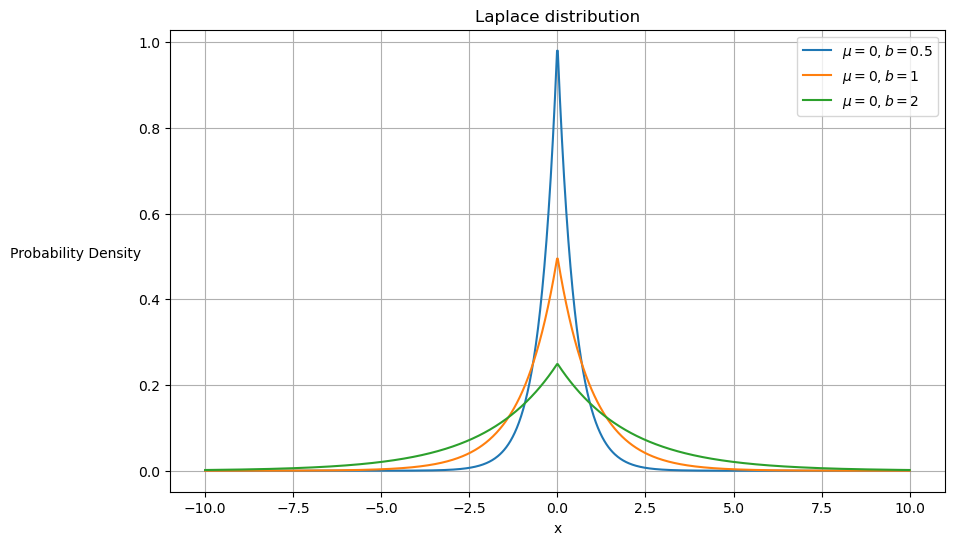

In [15]:
mu = [0, 0, 0]
b = [0.5, 1, 2]
x = np.linspace(-10, 10, 1000)

plt.figure(figsize=(10, 6))
for mu, b in zip(mu, b):
    y = laplace.pdf(x, loc=mu, scale=b)
    plt.plot(x, y, label=f'$\mu={mu}, b={b}$')

plt.title('Laplace distribution')
plt.xlabel('x')
plt.ylabel('Probability Density', rotation=0, labelpad=45)
plt.legend()
plt.grid(True)
plt.show()

Suppose we assume that the parameters $\beta_0, ..., \beta_p$ are i.i.d. with a Laplace distribution, i.e. $\beta_i \sim \text{Laplace}(0, \tau)$. The *conditional distribution* of $\boldsymbol{y}$ given $\boldsymbol{\Theta} = \beta_0, ..., \beta_p$ is still $N(X\boldsymbol{\beta}, \sigma^2 I)$, as the normality assumption is put on the errors. We note that if we follow the procedure above, the only modification is that the $L^2$ norm that appear on the prior is replaced by the $L^1$ norm, and we find that the MAP estimator is the lasso estimator with $\lambda = \frac{2\sigma^2}{\tau}$.



We note that in both distributions, the smaller the value of $\tau$, the more the prior distribution penalizes large values of the parameters. Therefore the Bayesian interpretation of both shrinkage methods is that we are adding a bias towards smaller values of the parameters by building in a prior belief on the distribution of the parameters, and the smaller the value of $\tau$, the stronger the bias. Note that as $\tau \to 0, \lambda \to \infty$, which coincides with the intuition that larger values of $\lambda$ leads to higher penalization. 